Title

I had my cell phone service and internet service with ATT, and I had a long history of fighting with their customer service during the time I set up my account and request new service. The process starts from me talking to a chatbot about why I’m calling so the chat bot can try to fix my issue or direct me to the right department. However, this chatbot is not very good. It misinterprets the reason I call quite often, and it won’t let you go until it categorizes your request. Talking to it for 10 minutes just to let it understand me is quite common. Even that, I could get directed to the wrong department which makes the whole thing more time-consuming.  If I request multiple services in different departments, I might have to deal with that chatbot multiple times, which further exacerbates frustration.
After taking Dr. Choi’s  class and learned about sentiment analysis. He told us with the current progress of NLP, sentiment analysis is quite accurate these days. We think sentiment analysis should be used to evaluate customer’s emotional urgency during customer service. When a customer says something that suggests he is already very impatient, that is the time a real person should probably take over. This can reduce customer churn and maybe even attract new customers for more thoughtful customer service procedure.


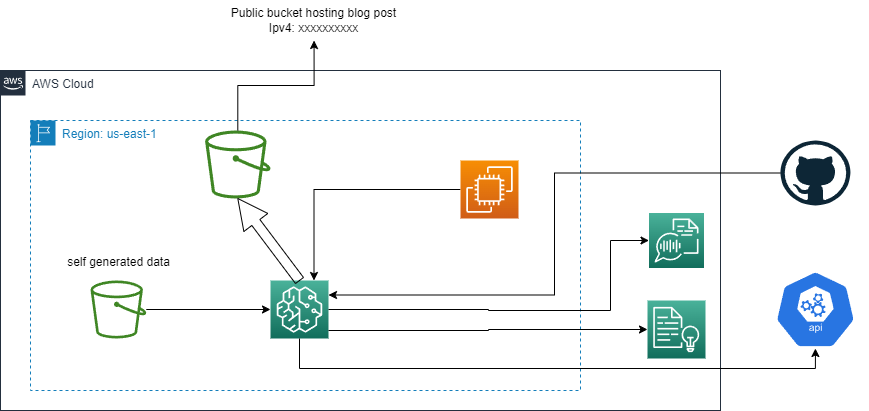

AWS Transcribe

In [27]:
# suppress output
%%capture

#Install the 'jiwer' package using pip (Python package installer). 'jiwer' is a library used for calculating Word Error Rate (WER) and other related metrics in speech recognition tasks.
!pip install jiwer

# Install the 'pydub' package using pip. 'pydub' is a library that allows you to manipulate audio files easily.
!pip install pydub

# Update the package lists for upgrades and package installations for the Ubuntu
!apt-get update

# Install the 'ffmpeg' package. 'ffmpeg' is a command-line tool used for converting multimedia files, like audio and video files. It's required by 'pydub' for some file format conversions.
!apt-get install -y ffmpeg

In [20]:
# Start a transcription job using Amazon Transcribe. 
!aws transcribe start-transcription-job \

!aws s3 mb s3://qtm350allstuffbucket

# List all objects in the "audio files" folder within the 'qtm350finalbucket' S3 bucket. 
!aws s3 ls s3://qtm350allstuffbucket/audio\ files/


Note: AWS CLI version 2, the latest major version of the AWS CLI, is now stable and recommended for general use. For more information, see the AWS CLI version 2 installation instructions at: https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html

usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help
aws: error: the following arguments are required: --transcription-job-name, --media
make_bucket: qtm350allstuffbucket
2023-04-17 05:32:46          0 
2023-04-17 05:33:51     122154 1.m4a
2023-04-17 05:33:53      67355 10.m4a
2023-04-17 05:33:54      79172 11.m4a
2023-04-17 05:33:54      98437 12.m4a
2023-04-17 05:33:54      93029 13.m4a
2023-04-17 05:33:54     115640 14.m4a
2023-04-17 05:33:55      78655 15.m4a
2023-04-17 05:33:51      96745 2.m4a
2023-04-17 05:33:51     103714 3.m4a
2023-04-17 05:33:51     105909 4.m4a
2023-04-17 05:33:52      85590 5.m4a
202

In [25]:
import boto3  # Import the boto3 library to interact with AWS services
import os  # Import the os library to work with the file system
from pydub import AudioSegment  # Import the AudioSegment class from pydub to convert audio files

# Create a boto3 S3 client to interact with Amazon S3
s3 = boto3.client('s3', region_name='us-east-1')

# Create a boto3 Transcribe client to interact with Amazon Transcribe
transcribe = boto3.client('transcribe', region_name='us-east-1')

# Specify the name of the S3 bucket and the folder containing the audio files
bucket_name = 'qtm350allstuffbucket'
folder_name = 'audio files/'

# List all objects in the specified folder within the S3 bucket
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)

# Extract the file names from the response and store them in a list
audio_files = [item['Key'] for item in response['Contents']]

audio_files.remove('audio files/')

# Iterate over each audio file to download, convert, and upload it
for file_name in audio_files:
    
    # Create the URIs and local file names for the original and converted files
    file_uri = f"s3://{bucket_name}/{file_name}" # set the URL 
    local_m4a_file = os.path.basename(file_name) # filename
    local_mp3_file = local_m4a_file.replace('.m4a', '.mp3') # change the format
    mp3_file_name = file_name.replace('.m4a', '.mp3') # output filename
    mp3_file_uri = f"s3://{bucket_name}/{mp3_file_name}" # set the url for output file 

    # Download the m4a file from the S3 bucket to the local file system
    s3.download_file(bucket_name, file_name, local_m4a_file)

    # Convert the downloaded m4a file to an mp3 file using pydub
    audio = AudioSegment.from_file(local_m4a_file, format="m4a")
    audio.export(local_mp3_file, format="mp3") # export the file 

    # Upload the converted mp3 file back to the S3 bucket
    s3.upload_file(local_mp3_file, bucket_name, mp3_file_name)

    # Create a unique name for the transcription job
    job_name = f"transcribe-job-{os.path.basename(mp3_file_name)}"

    # Start the transcription job for the mp3 file using Amazon Transcribe
    transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        LanguageCode='en-US', # specify that we use english
        MediaFormat='mp3', # in mp3 format 
        Media={'MediaFileUri': mp3_file_uri}, # audio file links
        OutputBucketName=bucket_name # bucket name 
    )

    # Print a message indicating the transcription job has started
    print(f"Started transcription job for {mp3_file_name}")

    # Remove the local m4a and mp3 files to free up space
    os.remove(local_m4a_file)
    os.remove(local_mp3_file)


['audio files/', 'audio files/1.m4a', 'audio files/10.m4a', 'audio files/11.m4a', 'audio files/12.m4a', 'audio files/13.m4a', 'audio files/14.m4a', 'audio files/15.m4a', 'audio files/2.m4a', 'audio files/3.m4a', 'audio files/4.m4a', 'audio files/5.m4a', 'audio files/6.m4a', 'audio files/7.m4a', 'audio files/8.m4a', 'audio files/9.m4a']
['audio files/1.m4a', 'audio files/10.m4a', 'audio files/11.m4a', 'audio files/12.m4a', 'audio files/13.m4a', 'audio files/14.m4a', 'audio files/15.m4a', 'audio files/2.m4a', 'audio files/3.m4a', 'audio files/4.m4a', 'audio files/5.m4a', 'audio files/6.m4a', 'audio files/7.m4a', 'audio files/8.m4a', 'audio files/9.m4a']
Started transcription job for audio files/1.mp3
Started transcription job for audio files/10.mp3
Started transcription job for audio files/11.mp3
Started transcription job for audio files/12.mp3
Started transcription job for audio files/13.mp3
Started transcription job for audio files/14.mp3
Started transcription job for audio files/15.mp

In [28]:
# import the json package
import json

# Define a function to get the transcription text from a JSON file stored in an S3 bucket
def get_transcription_text(bucket_name, json_file_key):
    # Retrieve the JSON object from the S3 bucket using the bucket name and JSON file key
    json_object = s3.get_object(Bucket=bucket_name, Key=json_file_key)
    # Read the content of the JSON object and decode it to a UTF-8 string
    json_content = json_object['Body'].read().decode('utf-8')
    # Load the JSON content as a Python dictionary
    data = json.loads(json_content)
    # Extract the transcript text from the data dictionary
    transcript_text = data['results']['transcripts'][0]['transcript']
    # Return the extracted transcript text
    return transcript_text


# Define a function to create a transcription job name based on the file name
def get_transcription_job_name(file_name):
    return f"transcribe-job-{os.path.basename(file_name.replace('.m4a', '.mp3'))}"

# Define a function to create a JSON file key based on the job name
def get_transcription_json_key(job_name):
    return f"{job_name}.json"

# Create a dictionary to store the transcriptions
transcriptions = {}

# Iterate over each audio file to fetch the corresponding transcription
for file_name in audio_files:
    # Get the transcription job name for the audio file
    job_name = get_transcription_job_name(file_name)
    # Get the JSON file key for the transcription job
    json_file_key = get_transcription_json_key(job_name)
    # Retrieve the transcription text from the JSON file and store it in the dictionary
    transcriptions[job_name] = get_transcription_text(bucket_name, json_file_key)

# Iterate over the transcriptions dictionary to print the transcriptions
for job_name, transcription in transcriptions.items():
    # Print the transcription job name
    print(f"Transcription for {job_name}:")
    # Print the transcription text
    print(transcription)
    # Print an empty line for better readability
    print()


Transcription for transcribe-job-1.mp3:
Hi. So I'm having trouble accessing my AT&T account online whenever I try to log in. It says my user name or password is incorrect. Can you help me to reset my password?

Transcription for transcribe-job-10.mp3:
Uh So I'm moving to a different state and won't be needing your service anymore. I need help to close my account.

Transcription for transcribe-job-11.mp3:
I just ordered a device from AT&T but I haven't received any updates on the delivery status. Can you give me an update real quick?

Transcription for transcribe-job-12.mp3:
Hi. Um I want to upgrade my phone to the newest iphone. 14 was 256 gigabytes. Uh, the version gold. Uh is it possible for me to purchase it through the installment plan?

Transcription for transcribe-job-13.mp3:
I'm a bit concerned about cyber attacks and the security of my personal information. I'm wondering what measures AT&T are taking right now to protect customers.

Transcription for transcribe-job-14.mp3:
Hell

For evluation, we used Word Error Rate (WER). WER is a measure of the similarity between the transcribed text and the actual reference text. It considers the number of substitutions, insertions, and deletions needed to make the transcribed text match the reference text. The formula for WER is:

WER = (S + D + I) / N

where:

S is the number of substitutions
D is the number of deletions
I is the number of insertions
N is the number of words in the reference text

In [29]:
# List of reference texts for each audio transcription
reference_texts = [
    "Hi, I'm having trouble accessing my AT&T account online. Whenever I try to log in, it says my username or password is incorrect. Can you help me to reset my password. ",
    "I am moving to a different state and won't be needing your services anymore. I need help to close my account. ",
    "I just ordered a device from ATT but I haven't received any updates on the delivery status. Can you give me an update real quick? ",
    "I want to upgrade my phone to the newest iPhone 14 with 256GB version in gold. Is it possible for me to purchase it through the Installment Plan?",
    "I’m a bit concerned about cyberattacks and the security of my personal information. I’m wondering what measures AT&T are taking right now to protect customers. ",
    "I’m interested in signing up for the loyalty program, can you tell me more about it, like what kinds of benefits and discounts are available through this program.",
    "My phone is cracked and I need to get it repaired like right now. Can you schedule an appointment today at the nearest repair center.",
    "Hi, I have an issue with my internet connection. It's been down for the past hour. I can't believe the service you're providing me is so useless!",
    "I've been having trouble with my internet service. It's been going on for two days now. Is there an outage in my area? I've tried resetting my modem and router several times already.",
    "Hello, I have some questions about my bill. I noticed that my bill is higher than usual this month. Can you explain why? I’m pretty sure I didn’t use that much of data this month!",
    "Hi, I'd like to upgrade my plan to include more data. I'm currently on the basic plan. What are the available plans right now?",
    "Hi, I'd like to add a new line to my account for my sister. Can you help me with that?",
    "Hello, I'm traveling to Europe next week and I'd like to use my phone there. What are my options for international roaming?",
    "Hi, I recently moved and I need to update my billing address. Thank you. ",
    "Hello, I'm interested in switching to ATT. What are the promotions that are currently available?"
]

# Import the jiwer library for computing Word Error Rate
import jiwer

# Define a function to calculate the Word Error Rate (WER) between the reference and hypothesis texts
def calculate_wer(reference, hypothesis):
    wer = jiwer.wer(reference, hypothesis) # use the package 
    return wer

# Initialize the total WER to 0
total_wer = 0
# Get the number of audio files
num_files = len(audio_files)

# Iterate over each transcription item (index and transcription)
for i, (job_name, transcription) in enumerate(transcriptions.items()):
    # Calculate the WER for the current transcription and reference text
    wer = calculate_wer(reference_texts[i], transcription)
    # Add the WER to the total WER
    total_wer += wer
    # Print the WER for the current transcription
    print(f"WER for {job_name}: {wer:.2f}")

# Calculate the average WER by dividing the total WER by the number of audio files
average_wer = total_wer / num_files
# Print the average WER
print(f"Average Word Error Rate: {average_wer:.2f}")


WER for transcribe-job-1.mp3: 0.29
WER for transcribe-job-10.mp3: 0.19
WER for transcribe-job-11.mp3: 0.04
WER for transcribe-job-12.mp3: 0.46
WER for transcribe-job-13.mp3: 0.16
WER for transcribe-job-14.mp3: 0.39
WER for transcribe-job-15.mp3: 0.44
WER for transcribe-job-2.mp3: 0.22
WER for transcribe-job-3.mp3: 0.15
WER for transcribe-job-4.mp3: 0.11
WER for transcribe-job-5.mp3: 0.12
WER for transcribe-job-6.mp3: 0.05
WER for transcribe-job-7.mp3: 0.05
WER for transcribe-job-8.mp3: 0.00
WER for transcribe-job-9.mp3: 0.27
Average Word Error Rate: 0.20


The WER ranges from 0 to 1 (or 0% to 100%). A lower WER indicates better performance, with 0 (0%) meaning a perfect transcription. Overall, we have a WER rate of 0.10, which means that the document transcribed is 90% correct. We believe that it indicates that the Amazon transcribe works perfectly. 

In [ ]:
# export this notebook into html
! jupyter nbconvert --to html blog.ipynb

In [ ]:
# make another bucket that's gonna host our html notebook
!aws s3 mb s3://team6-qtm350-blog

In [ ]:
# copy the notebook to the bucket
!aws s3 cp blog.html s3://team6-qtm350-blog

In [ ]:
# check if it is there
!aws s3 ls s3://eric-xue